# Trying a Foundational Model

How well does a foundational model at captioning the radiology images?

In [2]:
#%pip install --upgrade --quiet pydantic-ai-slim[anthropic] anthropic

Note: you may need to restart the kernel to use updated packages.


In [36]:
import os
from dotenv import load_dotenv
load_dotenv("../keys.env")
assert os.environ["OPENAI_API_KEY"][:2] == "sk",\
       "Please specify the OPENAI_API_KEY access token in keys.env file"

In [2]:
# Needed in Jupyter environment See: https://ai.pydantic.dev/troubleshooting/ 
import nest_asyncio
nest_asyncio.apply()

## Read in messages.jsonl

In [21]:
import json
def read_messages(filename="messages.jsonl"):
    with open(filename, "r") as ifp:
        return [json.loads(line) for line in ifp.readlines()]

messages = read_messages()
messages[:3]

[{'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': 'You are an expert researcher in radiology.'}]},
   {'role': 'user',
    'content': [{'type': 'text',
      'text': 'Write a caption for this image explaining what it depicts, suitable for use in a research publication.'},
     {'type': 'image',
      'image': 'all_data/train/radiology/images/PMC4083729_AMHSR-4-14-g002.jpg'}]},
   {'role': 'assistant',
    'content': [{'type': 'text',
      'text': 'Computed tomography scan in axial view showing obliteration of the left maxillary sinus'}]}]},
 {'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': 'You are an expert researcher in radiology.'}]},
   {'role': 'user',
    'content': [{'type': 'text',
      'text': 'Write a caption for this image explaining what it depicts, suitable for use in a research publication.'},
     {'type': 'image',
      'image': 'all_data/train/radiology/images/PMC2837471_IJD2009-150251.001.jpg'}]},
   {'ro

## Invoke model on image

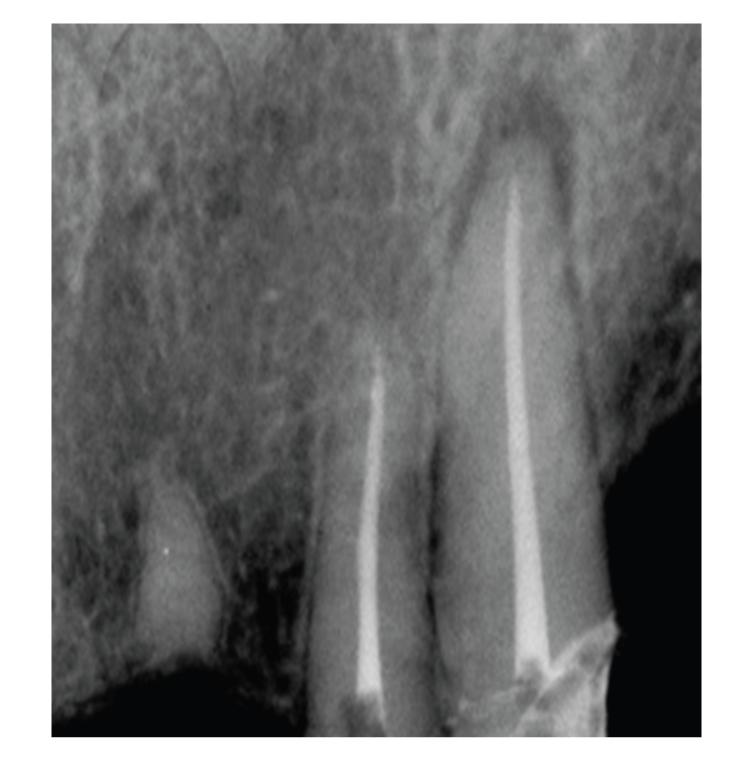

In [38]:
from IPython.display import Image as showImage
showImage(filename='all_data/train/radiology/images/PMC2837471_IJD2009-150251.001.jpg')

In [32]:
from pathlib import Path
from pydantic_ai import BinaryContent, Agent
import copy

def create_input_output(messages: list[dict]):
    input = [
        'Write a caption for this image explaining what it depicts, suitable for use in a research publication.'
    ]
    output = ""
    for msg in copy.deepcopy(messages):
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and "image" in element:
                # Get the image and read it in
                img_path = Path(element["image"])
                input.append(BinaryContent(data=img_path.read_bytes(), media_type="image/jpeg"))
        
        if msg.get("role", "unknown") == "assistant":
            output = msg.get("content")[0].get("text") 
            
    return input, output

# create_input_output(messages[1]['messages'])

In [37]:
agent = Agent('openai:gpt-4o-mini',
             system_prompt="You are an expert researcher in radiology.")

example_input, example_output = create_input_output(messages[1]['messages'])
print("**Expected:**\n", example_output, "\n****\n")
result = agent.run_sync(example_input)
print(result.data)

**Expected:**
 Bacterial contamination occurred after completion of root canal treatment in the tooth, which remained with a temporary filling for 15 month. 
****

**Caption:** Radiographic image displaying the periapical region of tooth roots. The image highlights the presence of apical radiolucencies, indicative of potential periapical pathology. The distinct radiographic characteristics suggest chronic apical periodontitis, warranting further clinical evaluation and management.


Well, that's pretty good, actually. But let's say the foundational model doesn't know ... let's train a smaller model to do the job.